 # Sentiment Analysis With Top 10 Year-End Billboard Hits of 2022



#### Importing libraries

In [4]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import string 
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from textblob import TextBlob
from flair.models import TextClassifier
from flair.data import Sentence

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### Song extraction and lyrics scraping

A well-known Brazilian music website (www.vagalume.com.br) was used to scrap lyrics from the top 10 year-end Billboard hits of 2022. 

In [5]:
list_url = ['https://www.vagalume.com.br/glass-animals/heat-waves.html',
            'https://www.vagalume.com.br/harry-styles/as-it-was.html',
            'https://www.vagalume.com.br/the-kid-laroi/stay-with-justin-bieber.html',
            'https://www.vagalume.com.br/adele/easy-on-me.html',
            'https://www.vagalume.com.br/ed-sheeran/shivers.html',
            'https://www.vagalume.com.br/jack-harlow/first-class.html',
            'https://www.vagalume.com.br/latto/big-energy.html',
            'https://www.vagalume.com.br/justin-bieber/ghost.html',
            'https://www.vagalume.com.br/kodak-black/super-gremlin.html',
            'https://www.vagalume.com.br/elton-john/cold-heart-with-dua-lipa-pnau-remix.html']

def scrap_song_url(url):
    page = requests.get(url)
    html = BeautifulSoup(page.text, 'html.parser')
    lyrics = html.find('div', id='lyrics').get_text(separator="\n")
    title = html.title

    return lyrics, title

raw_list = []

for url in list_url:
  raw_list.append(scrap_song_url(url))

df = pd.DataFrame(raw_list)

df.columns = ['lyrics', 'page_title']

df['page_title'] = df['page_title'].astype(str)

song_pattern = r'<title>(.*?) - .*? - VAGALUME<\/title>'

artist_pattern = r'<title>.*? - (.*?) - VAGALUME<\/title>'

df['song'] = df['page_title'].str.extract(song_pattern, expand=False)

df['artist'] = df['page_title'].str.extract(artist_pattern, expand=False)

df.head(2)

,lyrics,page_title,song,artist
0,"(Last night, all I think about is you)\n(Don't...",<title>Heat Waves - Glass Animals - VAGALUME</...,Heat Waves,Glass Animals
1,"Come on Harry, we wanna say ""Goodnight"" to you...",<title>As It Was - Harry Styles - VAGALUME</ti...,As It Was,Harry Styles


#### Lyrics cleaning and processing

The songs' lyrics were processed for better modeling by removing special characters such as "\n", non-words such as "(" and ")", punctuation and stop words and by lemmatization.

In [6]:
stop_words = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

df['processed_lyrics'] = df['lyrics'].str.lower()
df['processed_lyrics'] = df['processed_lyrics'].str.replace("\n"," ").str.replace(r"[^\w\d'\s]+","")
df['processed_lyrics'] = df['processed_lyrics'].str.strip()

def text_removal_lemmatization(text):
  stopwordremoval = " ".join([i for i in text.split() if i not in stop_words])
  punctuationremoval = ''.join(ch for ch in stopwordremoval if ch not in exclude)
  lemmatized = " ".join(lemma.lemmatize(word) for word in punctuationremoval.split())

  return lemmatized

df['processed_lyrics'] = df['processed_lyrics'].apply(text_removal_lemmatization)

<ipython-input-6-cfaf561e47b7>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed_lyrics'] = df['processed_lyrics'].str.replace("\n"," ").str.replace(r"[^\w\d'\s]+","")


## Exploratory data analysis

#### Plotting word clouds

The word clouds made from the lemmatized words allow us to pre-visualize tendencies of sentiment polarity in the songs. 

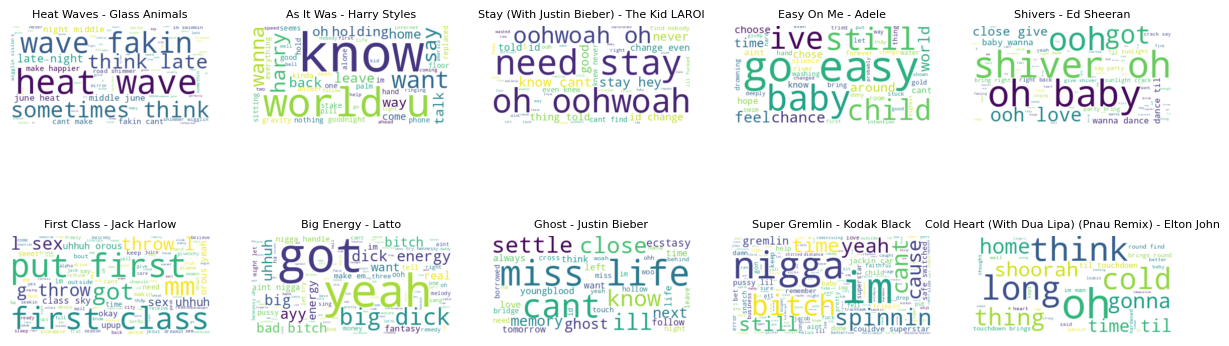

In [7]:
fig = plt.figure(figsize=(15,5))

for index, row in df.iterrows():

  plt.subplot(2, 5, index + 1)
  wordcloud = WordCloud(background_color="white").generate(row['processed_lyrics'])
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title(row['song'] + " - " + row['artist'], fontsize=8)
  plt.axis("off")

## Testing models 

#### VADER

VADER is a rule and lexicon-based sentiment analysis model. It classifies sentences or words using negative, positive and neutral scores based on a pre-defined set of rules and a sentiment lexicon. The compound score is the normalized sum of these scores. 

In [8]:
negative = []
neutral = []
positive = []
compound = []

sid = SentimentIntensityAnalyzer()

for i in df.index:
    scores = sid.polarity_scores(df['processed_lyrics'].iloc[i])
    negative.append(scores['neg'])
    neutral.append(scores['neu'])
    positive.append(scores['pos'])
    compound.append(scores['compound'])

df['negative'] = negative
df['neutral'] = neutral
df['positive'] = positive
df['compound'] = compound

df.head(2)

,lyrics,page_title,song,artist,processed_lyrics,negative,neutral,positive,compound
0,"(Last night, all I think about is you)\n(Don't...",<title>Heat Waves - Glass Animals - VAGALUME</...,Heat Waves,Glass Animals,last night think stop baby walk want baby thin...,0.13,0.723,0.147,0.3103
1,"Come on Harry, we wanna say ""Goodnight"" to you...",<title>As It Was - Harry Styles - VAGALUME</ti...,As It Was,Harry Styles,come harry wanna say goodnight holding back gr...,0.05,0.780,0.170,0.8555


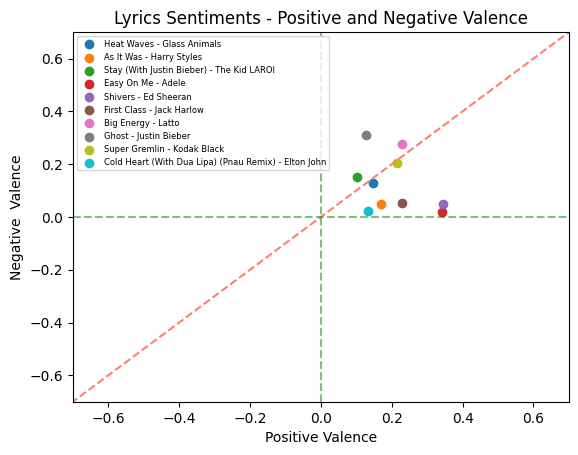

In [9]:
for _, row in df.iterrows():
  song_label = row['song'] + " - " + row['artist']
  plt.scatter(row['positive'], row['negative'], label=song_label)

plt.xlim([-0.7,0.7])
plt.ylim([-0.7,0.7])
x = list(np.arange(-1.0, 1.0, 0.1))
plt.plot(x, x, linestyle='--', color='salmon')
plt.title("Lyrics Sentiments - Positive and Negative Valence")
plt.xlabel('Positive Valence')
plt.ylabel('Negative  Valence')
plt.axvline(0, alpha=0.5, color='green', linestyle='--')
plt.axhline(0, alpha=0.5, color='green', linestyle='--')
plt.legend(fontsize=6)
plt.show()

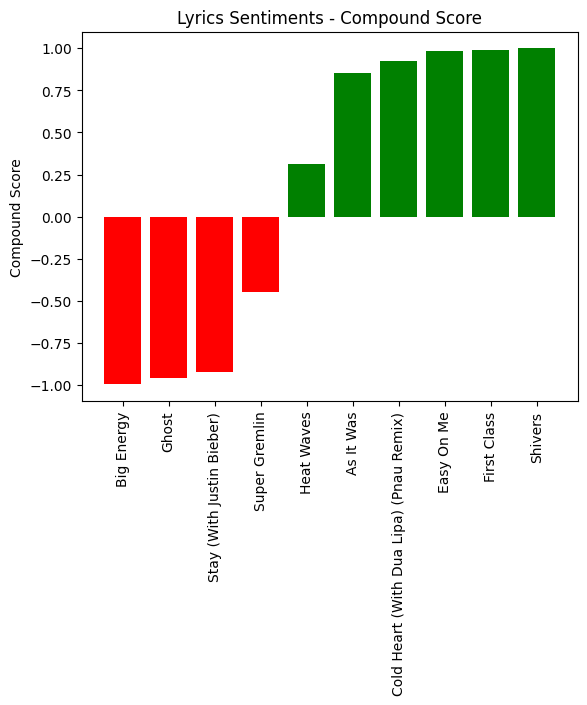

In [10]:
df_sort = df.sort_values(by='compound')
colormat=np.where(df_sort['compound'] > 0, 'g','r')
plt.bar(df_sort['song'], df_sort['compound'], color=colormat)
plt.xticks(rotation = 90)
plt.title("Lyrics Sentiments - Compound Score")
plt.ylabel('Compound Score')
plt.show()

#### TextBlob

TextBlob is also a rule and lexicon-based sentiment analysis model. It classifies sentences or words with a polarity score and a subjectivity score related to the polarity score.

In [11]:
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity
  
def getPolarity(text):
  return TextBlob(text).sentiment.polarity
  
df['TextBlob_Subjectivity'] = df['processed_lyrics'].apply(getSubjectivity)
df['TextBlob_Polarity'] = df['processed_lyrics'].apply(getPolarity)

df.head(2)

,lyrics,page_title,song,artist,processed_lyrics,negative,neutral,positive,compound,TextBlob_Subjectivity,TextBlob_Polarity
0,"(Last night, all I think about is you)\n(Don't...",<title>Heat Waves - Glass Animals - VAGALUME</...,Heat Waves,Glass Animals,last night think stop baby walk want baby thin...,0.13,0.723,0.147,0.3103,0.379798,-0.022727
1,"Come on Harry, we wanna say ""Goodnight"" to you...",<title>As It Was - Harry Styles - VAGALUME</ti...,As It Was,Harry Styles,come harry wanna say goodnight holding back gr...,0.05,0.780,0.170,0.8555,0.326667,0.270000


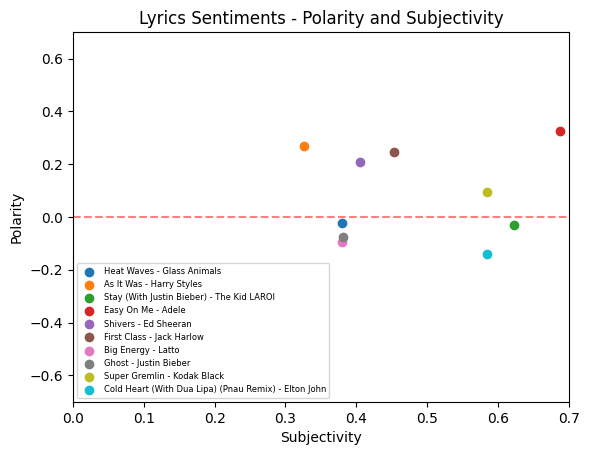

In [12]:
for _, row in df.iterrows():
  song_label = row['song'] + " - " + row['artist']
  plt.scatter(row['TextBlob_Subjectivity'], row['TextBlob_Polarity'], label=song_label)

plt.xlim([0.0,0.7])
plt.ylim([-0.7,0.7])
plt.title("Lyrics Sentiments - Polarity and Subjectivity")
plt.xlabel('Subjectivity')
plt.ylabel('Polarity')
plt.axhline(0, alpha=0.5, color='red', linestyle='--')
plt.legend(fontsize=6)
plt.show()

We can define a new metric for better comparison between models as:

 Confidence = 1 - Subjectivity Score

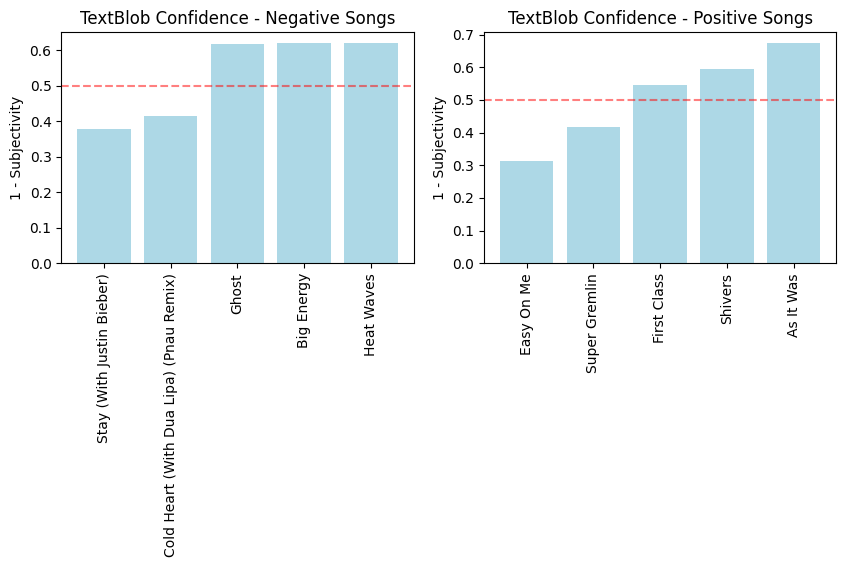

In [38]:
df_tblob_neg = df[df['TextBlob_Polarity'] < 0.0].sort_values(by='TextBlob_Subjectivity', ascending=False)
df_tblob_pos = df[df['TextBlob_Polarity'] > 0.0].sort_values(by='TextBlob_Subjectivity', ascending=False)

fig = plt.figure(figsize=(10,3))

ax1 = fig.add_subplot(121)

ax1.bar(df_tblob_neg['song'], 1.0-df_tblob_neg['TextBlob_Subjectivity'], color='lightblue')
ax1.xaxis.set_tick_params(rotation=90)
ax1.set_title("TextBlob Confidence - Negative Songs")
ax1.set_ylabel('1 - Subjectivity')
plt.axhline(0.5, alpha=0.5, color='red', linestyle='--')

ax2 = fig.add_subplot(122)

ax2.bar(df_tblob_pos['song'], 1.0-df_tblob_pos['TextBlob_Subjectivity'], color='lightblue')
ax2.xaxis.set_tick_params(rotation=90)
ax2.set_title("TextBlob Confidence - Positive Songs")
ax2.set_ylabel('1 - Subjectivity')
plt.axhline(0.5, alpha=0.5, color='red', linestyle='--')


plt.show()

#### Flair


Flair is a more complex NLP library based on pre-trained models and transfer learning. It provides improved contextual understanding of sentences for many language processing tasks and its models can be fine-tuned.  

In [14]:
classifier = TextClassifier.load('en-sentiment')

2023-06-04 19:32:23,647 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpm42maffs


100%|██████████| 253M/253M [00:15<00:00, 16.7MB/s]

2023-06-04 19:32:40,091 copying /tmp/tmpm42maffs to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2023-06-04 19:32:40,829 removing temp file /tmp/tmpm42maffs


In [15]:
def flair_predict(x):

  sentence = Sentence(x)

  classifier.predict(sentence)

  return sentence.labels[0].value, sentence.labels[0].score

df['Flair_Value'] = df['processed_lyrics'].apply(flair_predict).str[0]

df['Flair_Score'] = df['processed_lyrics'].apply(flair_predict).str[1]

df.head(2)

,lyrics,page_title,song,artist,processed_lyrics,negative,neutral,positive,compound,TextBlob_Subjectivity,TextBlob_Polarity,Flair_Value,Flair_Score
0,"(Last night, all I think about is you)\n(Don't...",<title>Heat Waves - Glass Animals - VAGALUME</...,Heat Waves,Glass Animals,last night think stop baby walk want baby thin...,0.13,0.723,0.147,0.3103,0.379798,-0.022727,NEGATIVE,0.966905
1,"Come on Harry, we wanna say ""Goodnight"" to you...",<title>As It Was - Harry Styles - VAGALUME</ti...,As It Was,Harry Styles,come harry wanna say goodnight holding back gr...,0.05,0.780,0.170,0.8555,0.326667,0.270000,NEGATIVE,0.971513


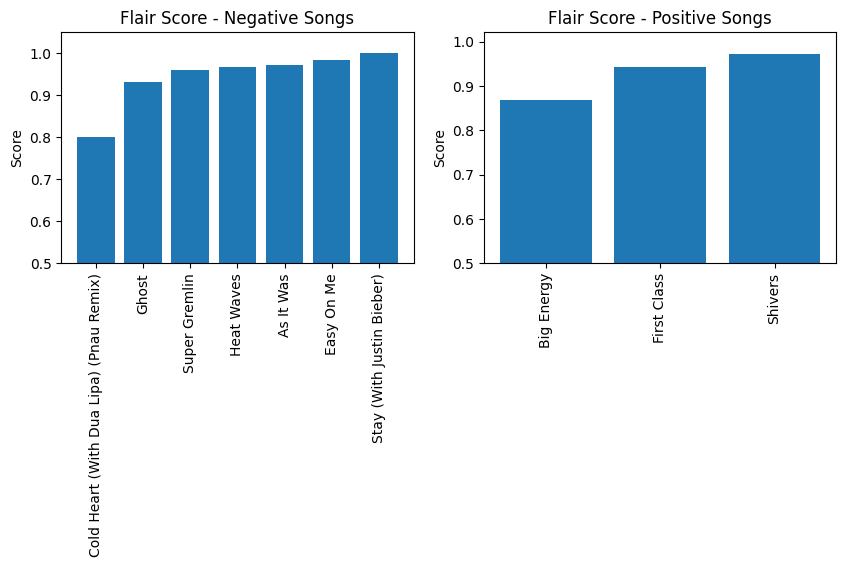

In [19]:
df_flair_neg = df[df['Flair_Value'] == 'NEGATIVE'].sort_values(by='Flair_Score')
df_flair_pos = df[df['Flair_Value'] == 'POSITIVE'].sort_values(by='Flair_Score')

fig = plt.figure(figsize=(10,3))

ax1 = fig.add_subplot(121)

ax1.bar(df_flair_neg['song'], df_flair_neg['Flair_Score'])
ax1.xaxis.set_tick_params(rotation=90)
ax1.set_title("Flair Score - Negative Songs")
ax1.set_ylabel('Score')
ax1.set_ylim(0.5)

ax2 = fig.add_subplot(122)

ax2.bar(df_flair_pos['song'], df_flair_pos['Flair_Score'])
ax2.xaxis.set_tick_params(rotation=90)
ax2.set_title("Flair Score - Positive Songs")
ax2.set_ylabel('Score')
ax2.set_ylim(0.5)

plt.show()

### Some observations:

"First Class" and "Shivers" were classified as positive songs using all three methods with high confidence. 

"As It Was" was considered positive by both VADER and TextBlob with high confidence, but negative by Flair (also with high confidence). This implies that "As It Was" could contain more contextual nuances than the two previous songs. We observe the same with "Easy on Me". 

A similar thing also happens with "Big Energy", which is positive for Flair, but negative for VADER and TextBlob. The song contains a fair amount of swear words and slangs that could be seen as very contextual.

In the matter of "Cold Heart", we see that it shows lower confidence scores with both TextBlob and Flair, while VADER gives it a high compound score. Checking VADER's positive and negative valence plot, however, we can see that the song positive score is considerably low, as is the negative score. We could say, thus, that the song tends to neutral. 